# Introduction

At these nodes multiple tests will be applied, implying that an example can travel down multiple paths of the decision tree, and arrive at multiple leaves

Hoeffding tree induction algorithm [8] to allow exploration of multiple options.


A Hoeffding Option Tree (HOT) is an advanced decision tree designed for online learning. It extends the standard Hoeffding Tree by allowing multiple branches (options) at each decision node, facilitating exploration of different paths concurrently. The HOT leverages the Hoeffding bound to make statistically robust decisions about splits using a finite sample size, ensuring that the splits are close to what would be chosen with infinite data.

The key advantages of HOT are:

Efficiency in Processing Data Streams: By using the Hoeffding bound, the HOT can decide splits based on a small subset of data, making it ideal for real-time data streams.
Improved Accuracy through Multiple Paths: Instead of committing to a single path for each decision, the HOT evaluates multiple possible branches, which can improve predictive performance.
Scalability: HOTs manage growth by controlling the number of options at each node, ensuring the tree does not become excessively large.
Option Nodes:
Option nodes are a fundamental component of the Hoeffding Option Tree. At these nodes, multiple candidate splits (options) are maintained. Each option represents a potential decision path the tree could take. When an option node is encountered, the tree can follow multiple paths simultaneously, and each path contributes to the final decision through a voting mechanism.

The role of option nodes includes:

Exploring Multiple Splits Simultaneously: This reduces the risk of missing the best split due to premature decisions based on limited data.
Enhancing Robustness: By maintaining multiple paths, the tree can handle unstable splits better, where minor changes in data could lead to different splits.
Balancing Tree Growth: Option nodes control tree complexity by limiting the number of concurrent paths, ensuring the tree remains manageable and efficient.


This project aims to 



In the ever-evolving field of machine learning, decision trees have been a cornerstone for both theoretical research and practical applications due to their simplicity and interpretability. This project explores the implementation of a [Hoeffding Option Tree (HOT)](https://link.springer.com/chapter/10.1007/978-3-540-76928-6_11) Classifier, which introduces the concept on Option Node to the classical Hoeffding Tree. 

The primary objective of this project is to highlight the advantages of HOT as an online learning classifier and to provide a comprehensive comparison with the (offline) Decision Tree and the Hoeffding Tree. This comparison is crucial for understanding the trade-offs between offline and online learning paradigms and for selecting the appropriate model based on the specific requirements of the application at hand. For simplicity, the model(s) have been trained on the well known _iris_ dataset, where, with its simplicity is a good starting point to illustrate and test classification task. 

This project is integrated with the [_River_ library](https://riverml.xyz/latest/), a Python framework for online machine learning, which facilitates the implementation and evaluation of these tree-based models. Through this integration, we demonstrate how these algorithms can be applied in practical settings, particularly focusing on their performance in terms of accuracy, computational efficiency, and adaptability to data streams.

<center>Hoffding Option Tree</center>
<center><img src="imgs/hot.png"></center>

# Implementative Choices

<center>Tree Building</center>
<center><img src="imgs/HOT-building.png"></center>


# Comparison

In this section is presented a comparative analysis between the performances of Hoeffding Option Tree classifier with the classical _Decision Tree_ classifier from scikit-learn library and the _Hoffding Tree_ classifier from the River library. This comparison is based on several evaluation metrics, including accuracy, precision, recall and computational efficiency.

## Offline Decision Tree - Sklearn

In [97]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.3, stratify=iris.target, random_state=42
)
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
print(f'Model accuracy: {accuracy:.4f}')

results = dict()
results["Offline Decision Tree"] = dict(model=model,Accuracy=[accuracy], cm=cm)

Model accuracy: 0.9778


## Hoeffding Tree (River) and Hoeffding Option Tree

In [109]:
from river.tree import HoeffdingTreeClassifier
from hoeffding_option_tree import HoeffdingOptionTreeClassifier
from river.stream import iter_sklearn_dataset
from river.metrics import Accuracy
from river.evaluate import iter_progressive_val_score
import copy

def reformat(generator) -> dict:
    out = dict()
    for el in generator:
        for key in el:
            value = copy.deepcopy(el[key])
            if key == "Time":
                value = round(value.total_seconds() * 1000, 3)
            elif key == "Memory":
                value = round(value / 1024, 2)
            elif key == "Accuracy":
                cm = value.cm
                value = value.get()
            if key in out:
                out[key].append(value)
            else:
                out[key] = [value]
    out["cm"] = cm
    return out

from sklearn import datasets
iris = datasets.load_iris()

if "results" not in locals():
    results = dict()

results["Hoeffding Tree"] = reformat(iter_progressive_val_score(dataset=iter_sklearn_dataset(iris, shuffle=True, seed=42), 
                                                       model=HoeffdingTreeClassifier(tau=1.5, grace_period=3), 
                                                       metric=Accuracy(), 
                                                       measure_memory=True, measure_time=True))

results["Hoeffding Option Tree"] = reformat(iter_progressive_val_score(dataset=iter_sklearn_dataset(iris, shuffle=True, seed=42), 
                                                              model=HoeffdingOptionTreeClassifier(tau=1.5, grace_period=3, delta_prime=0.955, max_options=3), 
                                                              metric=Accuracy(), 
                                                              measure_memory=True, measure_time=True))

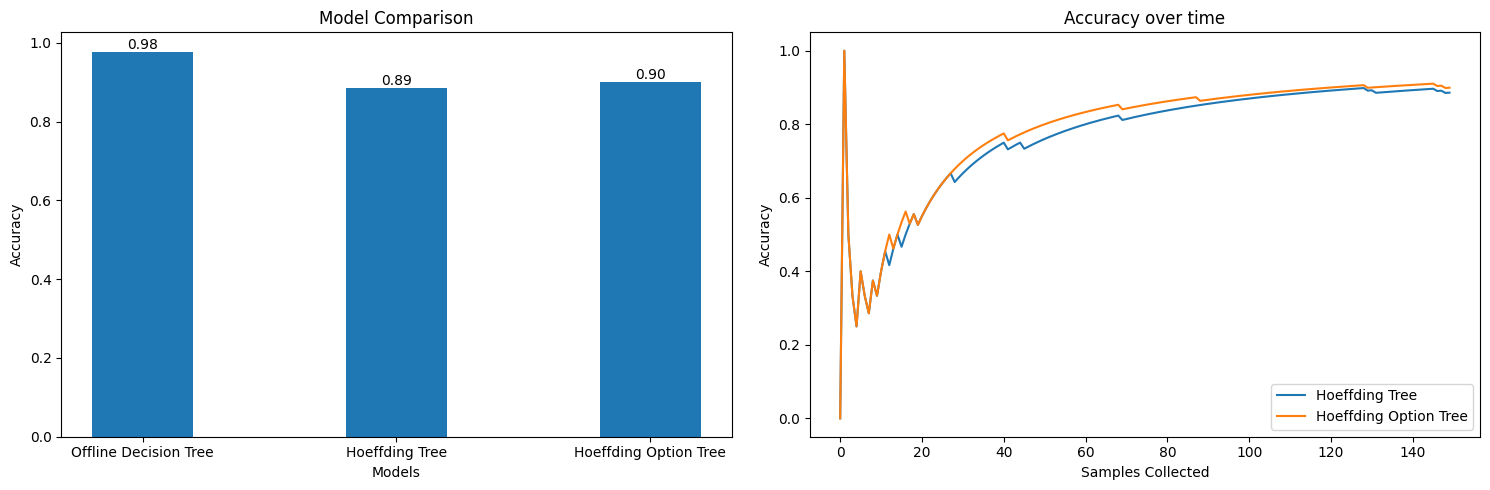

In [115]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Bar plot
data = {model: results[model]["Accuracy"][-1] for model in results}
models = list(data.keys())
values = list(data.values())

bars = axs[0].bar(models, values, width=0.4)
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom')

axs[0].set_xlabel("Models")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Model Comparison")

# Second subplot: Line plot
for model in results:
    if len(results[model]["Accuracy"]) < 2:
        continue
    data = results[model]["Accuracy"]
    axs[1].plot(data, label=model)

axs[1].legend()
axs[1].set_title("Accuracy over time")
axs[1].set_xlabel("Samples Collected")
axs[1].set_ylabel("Accuracy")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

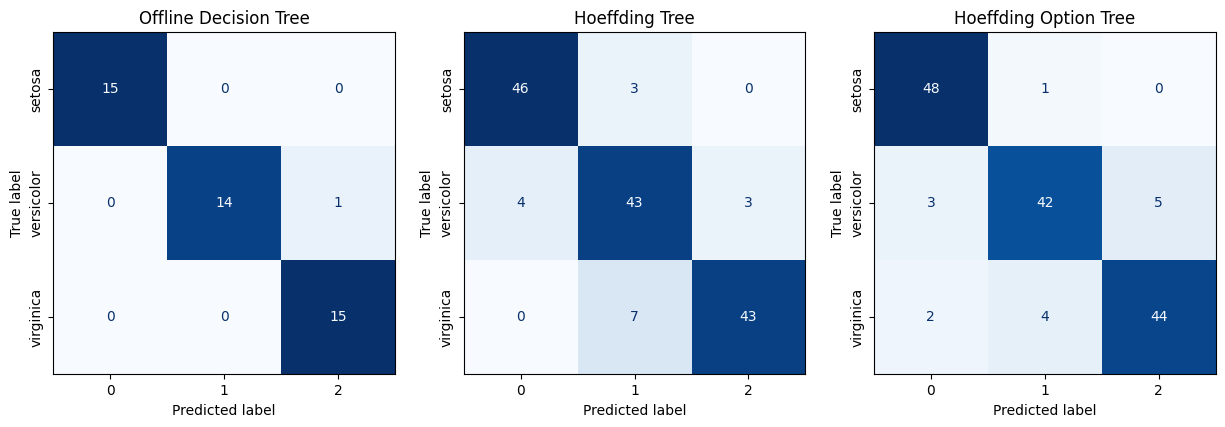

In [116]:
import river
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
label_mapping = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

n = len(results.keys())
fig, axs = plt.subplots(1, n, figsize=(15, 15))

for i, model in enumerate(results):
    cm = results[model]["cm"]
    # convert river.metrics.ConfusionMatrix to numpy.ndarray in order to be plotted by Sklearn.metrics.ConfusionMatrixDisplay
    if isinstance(cm, river.metrics.ConfusionMatrix):
        labels = list(cm.classes)
        cm = np.array([[cm[x][y] for y in labels] for x in labels])
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axs[i], cmap=plt.cm.Blues, colorbar=False)
    axs[i].set_yticklabels(list(map(label_mapping.get, label_mapping.keys())), rotation=90, va="center")
    axs[i].set_title(model)

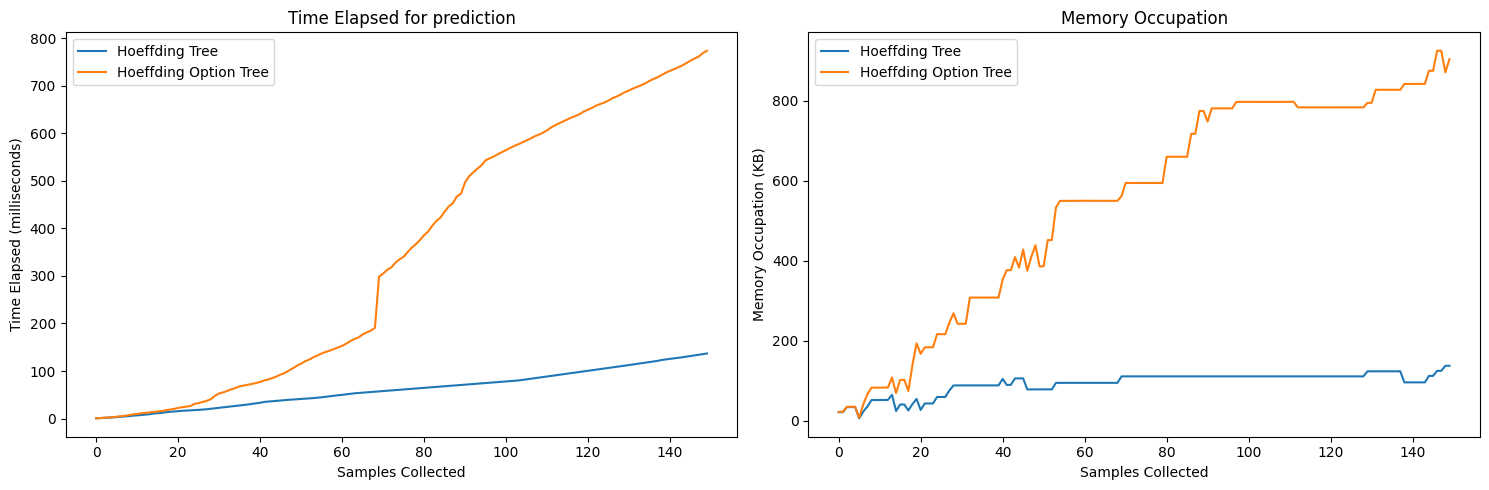

In [125]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Bar plot
for model in results:
    if "Time" not in results[model] or "Memory" not in results[model]:
        continue

    data = results[model]["Time"]
    axs[0].plot(data, label=model)
    
    data = results[model]["Memory"]
    axs[1].plot(data, label=model)
    
axs[0].legend() 
axs[0].set_title("Time Elapsed for prediction")
axs[0].set_xlabel("Samples Collected")
axs[0].set_ylabel("Time Elapsed (milliseconds)")

axs[1].legend()
axs[1].set_title("Memory Occupation")
axs[1].set_xlabel("Samples Collected")
axs[1].set_ylabel("Memory Occupation (KB)")

plt.tight_layout()
plt.show()